In [12]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr
from ast import literal_eval

In [13]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_1 where submit_time >= '2023-09-01';"  # Replace 'your_table_name' with the actual table name
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 101


### Filter the data fetched from database

In [14]:
df['bot_detected'] = df['bot_detected'].astype(int)
df['ideology_answers'] = df['ideology_answers'].apply(literal_eval)
df['additional_answers'] = df['additional_answers'].apply(literal_eval)

# attention check
df_attention_check_failed = df[df['attention_passed'] == 0]
print("These participants failed attention check:", df_attention_check_failed['participantId'].tolist(), "\n")
df = df[df['attention_passed'] == 1]

# reason
selected_reason_wrap = df[(df['reason'] != '') & (df['reason'] != 'None') & (df['reason'] != 'none') & (df['bot_detected'] > 0)]
for _, row in selected_reason_wrap.iterrows(): 
    print(int(row['bot_detected']), row['reason'])

# drop columns
columns_to_drop = ['assignmentId', 'projectId', 'attention_passed', 'total_time', 'submit_time', 'reason', 'identity_choices']
df.drop(columns_to_drop, axis=1, inplace=True)
df.head()

These participants failed attention check: ['65AE4015EAA44341B8F75ADA32A04DDA', '7574B205603B4178A51D9DD33E874DF7', '842B62B60C164567BF1794FEF9D91469', 'BADA027D68B84532A5134BF9D32B045F'] 

33 real people are unpredictable, this was to smooth to have real "partners"
31 I felt that the other person was a bot because they constantly disagreed with me and didn't deviate.
43 I chose bot for one of them because I just had a gut feeling about that one.
33 It would be too challenging to have actual live participants in a study set up like this. 
32 I thought it might be a bot because these kinds of studies do that a lot. 
33 I don't believe I was interacting with real people. Rather, I think a hypothesis was being tested.
33 You can't get three people simultaneously taking this test.
66 I definitely thought it was a bot for both because they just clearly followed a stereotype.
55 I did not pick bot
33 They answered too exactly like "left" and "right" stereotypes that I don't even agree with.


,participantId,ideologies,ideology_answers,additional_answers,bot_detected
0,0163260E3DF74A1E8CA46ADD5D792370,"[-1, 0, 2]","[{'answers': [0, 0, 0], 'time_to_answer': [5.8...","[[1, 0, -0.9], [2, 2], [-1, 1]]",66
1,03DE8461A90E4AE08F72F2258BBA7832,"[-1, 0, 1]","[{'answers': [1, 1, 1], 'time_to_answer': [4.5...","[[2, -1.8, -2], [-2, 1.5], [-0.5, 1.8]]",52
2,0534356469D74809A75902C69E6E0BD6,"[-2, 0, 1]","[{'answers': [1, 0, 0], 'time_to_answer': [9.9...","[[1.1, -1, -1], [-1, 2], [-1.7, 2]]",51
3,08384FE1523E41528B20E2C37BE811AC,"[-2, 0, 1]","[{'answers': [0, 1, 1], 'time_to_answer': [5.6...","[[2, -2, -0.9], [0, 1.5], [-1.1, 1.5]]",33
4,0AFC8075954343C9939BEAAD2E48C7DE,"[-1, 0, 1]","[{'answers': [0, 0, 0], 'time_to_answer': [9.7...","[[-0.4, -0.7, -0.3], [1.2, 1], [1, 1]]",33


### Merge connect platform user data

In [10]:
connect_data_path = 'data/connect_raw_data/pilot_1.csv'
connect_df = pd.read_csv(connect_data_path)

connect_ideology_mapping = {
    'Conservative': 2,
    'Liberal': -2,
    'Somewhat Liberal': -1,
    'Somewhat Conservative': 1,
    'Moderate': 0
}

connect_df['Political Ideology'] = connect_df['Political Ideology'].map(connect_ideology_mapping)

df['connect_ideology'] = None
row_index_to_drop = []      # exists in database but not on connect platform
for index, row in df.iterrows():
    id = row['participantId']
    connect_search_result = connect_df[connect_df['ParticipantId'] == id]
    connect_search_result.reset_index(drop=True, inplace=True)
    if len(connect_search_result):
        df.at[index, 'connect_ideology'] = connect_search_result.at[connect_search_result.index.tolist()[0], 'Political Ideology']
    else:
        row_index_to_drop.append(index)

print("Number of rows to drop:", len(row_index_to_drop))

def map_reported_ideology(row):
    reported_ideology = row['additional_answers'][0][1]
    return reported_ideology
    # if reported_ideology >= 1.2:
    #     return 2
    # elif reported_ideology >= 0.4 and reported_ideology < 1.2:
    #     return 1
    # elif reported_ideology >= -0.4 and reported_ideology < 0.4:
    #     return 0
    # elif reported_ideology >= -1.2 and reported_ideology < -0.4:
    #     return -1
    # else:
    #     return -2

df['reported_ideology'] = df.apply(map_reported_ideology, axis=1)
delta = df['reported_ideology'].to_numpy() - df['connect_ideology'].to_numpy()
delta = delta.astype(float)
rmse = np.sqrt(delta ** 2).mean()
print(f"rmse of ideology using mapping: {rmse:.3f}")
columns_to_drop=['connect_ideology', 'ideologies']
df.drop(columns_to_drop, axis=1, inplace=True)
df.set_index('participantId', inplace=True)

Number of rows to drop: 97


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

### Bot detection
1. How many participants detected bots
2. Whether the similarity of ideologies affects probability of bot detection

In [15]:
df_bot_detection = df.copy()
df_bot_detection.set_index('participantId')

def translate_bot_detection(bot_detected):
    first = bot_detected // 10
    second = bot_detected % 10
    return [first == 3, second == 3]

def judge_if_bots_have_same_ideology(additional_answers):
    if additional_answers[0][1] == 0:
        return [-1, -1]
    else:
        ret = []
        for bot_index in [0, 2]:
            multiplication = additional_answers[0][1] * additional_answers[0][bot_index]
            if multiplication > 0:
                ret.append(1)
            elif multiplication < 0:
                ret.append(0)
            else:
                ret.append(-1)
        return ret

df_no_clue = (df_bot_detection['bot_detected'] == 66)
print(f"Ratio of participants who answered 'no clue' for both bots: {df_no_clue.mean():.2%}")
df_bot_detection['bot_detected'] = df_bot_detection['bot_detected'].apply(translate_bot_detection)
df_bot_detection['bot_ideologies'] = df_bot_detection['additional_answers'].apply(lambda answers_wrap: [answers_wrap[0][0], answers_wrap[0][2]])
df_bot_detection['bot_same_ideology'] = df_bot_detection['additional_answers'].apply(judge_if_bots_have_same_ideology)
df_bot_detection['bot_detection_exists'] = df_bot_detection['bot_detected'].apply(lambda bot_detected: bot_detected[0] or bot_detected[1])
ratio = df_bot_detection['bot_detection_exists'].mean()
print(f"There are {ratio:.2%} participants who detected at least 1 bot")
df_bot_detection.drop('bot_detection_exists', axis=1, inplace=True)

Ratio of participants who answered 'no clue' for both bots: 21.65%
There are 26.80% participants who detected at least 1 bot


In [16]:
df_bot_detection_exploded = df_bot_detection.explode(['bot_same_ideology', 'bot_ideologies', 'bot_detected'])
df_bot_detection_exploded_without_medium = df_bot_detection_exploded[df_bot_detection_exploded['bot_same_ideology'] != -1]
df_bot_detection_exploded_without_medium_each_ideology = df_bot_detection_exploded_without_medium.groupby('bot_same_ideology')
bot_detection_rate = df_bot_detection_exploded_without_medium_each_ideology['bot_detected'].mean()
print(bot_detection_rate)

bot_same_ideology
0    0.259740
1    0.194444
Name: bot_detected, dtype: float64


In [17]:
df_answer_analysis = df_bot_detection.copy()

def get_answer_distances(ideology_answers):
    ret = [0, 0]
    for ideology_answer in ideology_answers:
        ret[0] += abs(ideology_answer['answers'][0] - ideology_answer['answers'][1])
        ret[1] += abs(ideology_answer['answers'][2] - ideology_answer['answers'][1])
    return ret

def get_ideology_distances(additional_answers):
    return [abs(additional_answers[0][0] - additional_answers[0][1]), abs(additional_answers[0][2] - additional_answers[0][1])]

df_answer_analysis['answer_distances'] = df_answer_analysis['ideology_answers'].apply(get_answer_distances)
df_answer_analysis['ideology_distances'] = df_answer_analysis['additional_answers'].apply(get_ideology_distances)
df_answer_analysis.drop(['ideology_answers', 'additional_answers', 'bot_same_ideology', 'ideologies'], axis=1, inplace=True)
df_answer_analysis.head()
df_bots_exploded = df_answer_analysis.explode(['bot_detected', 'bot_ideologies', 'answer_distances', 'ideology_distances'])
df_bots_exploded['answer_distances'] = df_bots_exploded['answer_distances'].astype(int)
df_bots_exploded['ideology_distances'] = df_bots_exploded['ideology_distances'].astype(float)
df_bots_exploded.head()

,participantId,bot_detected,bot_ideologies,answer_distances,ideology_distances
0,0163260E3DF74A1E8CA46ADD5D792370,False,1,6,1.0
0,0163260E3DF74A1E8CA46ADD5D792370,False,-0.9,0,0.9
1,03DE8461A90E4AE08F72F2258BBA7832,False,2,8,3.8
1,03DE8461A90E4AE08F72F2258BBA7832,False,-2,3,0.2
2,0534356469D74809A75902C69E6E0BD6,False,1.1,5,2.1


In [20]:
pearsonr(df_bots_exploded['answer_distances'], df_bots_exploded['ideology_distances'])

PearsonRResult(statistic=0.5893736996537613, pvalue=1.5624662672064334e-19)

In [146]:
print(df_bots_exploded['answer_distances'].corr(df_bots_exploded['ideology_distances']))
df_bots_exploded_bot_detected = df_bots_exploded[df_bots_exploded['bot_detected'] == True]
print(df_bots_exploded_bot_detected['answer_distances'].corr(df_bots_exploded_bot_detected['ideology_distances']))
df_bots_exploded_bot_not_detected = df_bots_exploded[df_bots_exploded['bot_detected'] == False]
print(df_bots_exploded_bot_not_detected['answer_distances'].corr(df_bots_exploded_bot_not_detected['ideology_distances']))

0.6834059797772173
0.5906285290658994
0.6995272989846145


### Participant Analysis
- How many 'right' answers does a participant make
- What's the percentage of people of different ideologies who detect bots compared to the overall ideology distribution
- Relationship between answer distance and bot detection

In [54]:
from phase_1_statements import phase_1_statements

def phase_1_is_right(idx, answer, ideology):
    info = phase_1_statements[idx]
    assert info['type'] != 'preference', "Cannot judge if is right for question of preference"
    human_extreme = True if ideology < -1.2 or ideology >= 1.2 else False
    question_extreme = info['extreme']
    
    if ideology == 0.0:
        return False

    side = "left" if ideology < 0 else "right"
    if not question_extreme:
        return (info['left_attitude'] and (answer == 0 and side == 'left' or answer == 1 and side == 'right')) or (
            not info['left_attitude'] and (answer == 0 and side == 'right' or answer == 1 and side == 'left')
        )
    else:
        return info['left_attitude'] and (answer == 0 and side == 'left' and human_extreme) or (answer == 1 and not human_extreme) or (
            not info['left_attitude'] and (answer == 0 and side == 'right' and human_extreme) or (answer == 1 and not human_extreme)
        )

In [100]:
def percentage_of_right_answers(row):
    human_index = 1
    answers_wraps = row['ideology_answers']
    question_num = len(answers_wraps)
    assert question_num == 10, "Number of questions is not 10"
    right_num = 0
    for answer_wrap in answers_wraps:
        right_num += phase_1_is_right(answer_wrap['idx_of_question'], answer_wrap['answers'][human_index], row['reported_ideology'])
    return right_num / question_num

df['right_percentage'] = df.apply(percentage_of_right_answers, axis=1)
df.head()

,ideology_answers,additional_answers,bot_detected,reported_ideology,ideology_label,right_percentage
participantId,,,,,,
089660F0CC9342DD8B346ADBBCF0DA74,"[{'answers': [0, 0, 1], 'time_to_answer': [22....","[[-1.3, -2, 1.8], [1.4, 0.3], [1.3, -0.4]]",0,-2.0,Liberal,0.7
098F41CFB27E489E9FB7B2BC628C94D3,"[{'answers': [0, 0, 1], 'time_to_answer': [28....","[[-2, -2, 1], [2, -1], [2, -1]]",0,-2.0,Liberal,0.8
0AA37D5D01BA4B76A3FF64C0B1F49B70,"[{'answers': [1, 1, 0], 'time_to_answer': [14....","[[0.7, 0, -0.6], [1, 1], [-0.2, -0.3]]",2,0.0,Moderate,0.0
0B912B6B2279490E8F137A6EF759DE77,"[{'answers': [1, 1, 1], 'time_to_answer': [28....","[[-1, -1.5, 1.5], [1.2, -1.2], [1.2, -1.1]]",0,-1.5,Liberal,0.6
0BC2CA097EC04C0C8857A0ADA2469C09,"[{'answers': [1, 1, 0], 'time_to_answer': [16....","[[-2, -2, 2], [0, -2], [1, -2]]",2,-2.0,Liberal,0.8


In [102]:
right_ratio_no_middle = df[(df['reported_ideology'] >= 0.4) | (df['reported_ideology'] < -0.4)]['right_percentage'].mean()
right_ratio_moderate = df[((df['reported_ideology'] >= 0.4) & (df['reported_ideology'] < 1.2)) | ((df['reported_ideology'] <= -0.4) & (df['reported_ideology'] >= -1.2))]['right_percentage'].mean()
right_ratio_extreme = df[(df['reported_ideology'] < -1.2) | (df['reported_ideology'] >= 1.2)]['right_percentage'].mean()
right_ratio_conservative = df[(df['reported_ideology'] > 0)]['right_percentage'].mean()
right_ratio_liberal = df[(df['reported_ideology'] < 0)]['right_percentage'].mean()
right_ratio_no_middle, right_ratio_moderate, right_ratio_extreme, right_ratio_conservative, right_ratio_liberal

(0.6267857142857142,
 0.6482758620689654,
 0.6071428571428571,
 0.48846153846153845,
 0.7500000000000001)

### Bot detection

In [89]:
def map_reported_ideology(row):
    reported_ideology = row['reported_ideology']
    if reported_ideology >= -0.4 and reported_ideology < 0.4:
        return 'Moderate'
    elif reported_ideology >= 0.4 and reported_ideology < 1.2:
        return 'Somewhat Conservative'
    elif reported_ideology >= 1.2 and reported_ideology < 2:
        return 'Conservative'
    elif reported_ideology >= -1.2 and reported_ideology < -0.4:
        return 'Somewhat Liberal'
    else:
        return 'Liberal'

df['ideology_label'] = df.apply(map_reported_ideology, axis=1)
df.head()

,ideology_answers,additional_answers,bot_detected,reported_ideology,ideology_label
participantId,,,,,
089660F0CC9342DD8B346ADBBCF0DA74,"[{'answers': [0, 0, 1], 'time_to_answer': [22....","[[-1.3, -2, 1.8], [1.4, 0.3], [1.3, -0.4]]",0,-2.0,Liberal
098F41CFB27E489E9FB7B2BC628C94D3,"[{'answers': [0, 0, 1], 'time_to_answer': [28....","[[-2, -2, 1], [2, -1], [2, -1]]",0,-2.0,Liberal
0AA37D5D01BA4B76A3FF64C0B1F49B70,"[{'answers': [1, 1, 0], 'time_to_answer': [14....","[[0.7, 0, -0.6], [1, 1], [-0.2, -0.3]]",2,0.0,Moderate
0B912B6B2279490E8F137A6EF759DE77,"[{'answers': [1, 1, 1], 'time_to_answer': [28....","[[-1, -1.5, 1.5], [1.2, -1.2], [1.2, -1.1]]",0,-1.5,Liberal
0BC2CA097EC04C0C8857A0ADA2469C09,"[{'answers': [1, 1, 0], 'time_to_answer': [16....","[[-2, -2, 2], [0, -2], [1, -2]]",2,-2.0,Liberal


In [98]:
df_bot_detected = df[df['bot_detected'] >= 1]
print(f"{len(df_bot_detected) / len(df):.2%} participants detected at least 1 bot.")
df_bot_detected = df[df['bot_detected'] >= 2]
print(f"{len(df_bot_detected) / len(df):.2%} participants detected 2 bots.")

overall_ideology_count = df['ideology_label'].value_counts()
print(overall_ideology_count, end='\n\n')

bot_detected_ideology_count = df[df['bot_detected'] >= 1]['ideology_label'].value_counts()
print(bot_detected_ideology_count)

48.05% participants detected at least 1 bot.
24.68% participants detected 2 bots.
Liberal                  24
Moderate                 21
Somewhat Liberal         15
Somewhat Conservative    13
Conservative              4
Name: ideology_label, dtype: int64

Moderate                 10
Liberal                   9
Somewhat Liberal          8
Somewhat Conservative     7
Conservative              3
Name: ideology_label, dtype: int64


### Calculate sum of answer distances

In [8]:
def cal_ans_dis_sum(row):
    answers_wraps = json.loads(row['ideology_answers'])
    distance = [0, 0]
    for answer_wrap in answers_wraps:
        answers = answer_wrap['answers']
        distance[0] += abs(answers[1] - answers[0])
        distance[1] += abs(answers[1] - answers[2])
    return distance



def get_ideology_dis(row):
    additional_answers = json.loads(row['additional_answers'])[0]
    return [abs(additional_answers[1] - additional_answers[0]), abs(additional_answers[1] - abs(additional_answers[2]))]



def get_friendliness(row):
    additional_answers = json.loads(row['additional_answers'])
    return additional_answers[1]



def get_competence(row):
    additional_answers = json.loads(row['additional_answers'])
    return additional_answers[2]

df['answer_distance_sum'] = df.apply(cal_ans_dis_sum, axis=1)
df['ideology_distance'] = df.apply(get_ideology_dis, axis=1)
df['friendliness'] = df.apply(get_friendliness, axis=1)
df['competence'] = df.apply(get_competence, axis=1)

columns_to_drop = ['ideology_answers', 'additional_answers', 'reported_ideology']
df.drop(columns_to_drop, axis=1, inplace=True)
df.head()

,participantId,bot_detected,answer_distance_sum,ideology_distance,friendliness,competence
7,089660F0CC9342DD8B346ADBBCF0DA74,0,"[1, 7]","[0.7, 3.8]","[1.4, 0.3]","[1.3, -0.4]"
9,098F41CFB27E489E9FB7B2BC628C94D3,0,"[0, 8]","[0, 3]","[2, -1]","[2, -1]"
10,0AA37D5D01BA4B76A3FF64C0B1F49B70,2,"[1, 9]","[0.7, 0.6]","[1, 1]","[-0.2, -0.3]"
12,0B912B6B2279490E8F137A6EF759DE77,0,"[2, 6]","[0.5, 3.0]","[1.2, -1.2]","[1.2, -1.1]"
13,0BC2CA097EC04C0C8857A0ADA2469C09,2,"[0, 10]","[0, 4]","[0, -2]","[1, -2]"


### ADS and ideology distance

For all participants:
Correlation of ideology distance and answer distance: 0.668, p value: 2.8765927736711674e-21
Correlation of friendliness and answer distance: -0.450, p value: 4.694168185210231e-09
Correlation of competence and answer distance: -0.514, p value: 9.690063057229043e-12
Correlation of friendliness and ideology distance: -0.498, p value: 5.167845750921315e-11
Correlation of competence and ideology distance: -0.558, p value: 5.724827830254371e-14


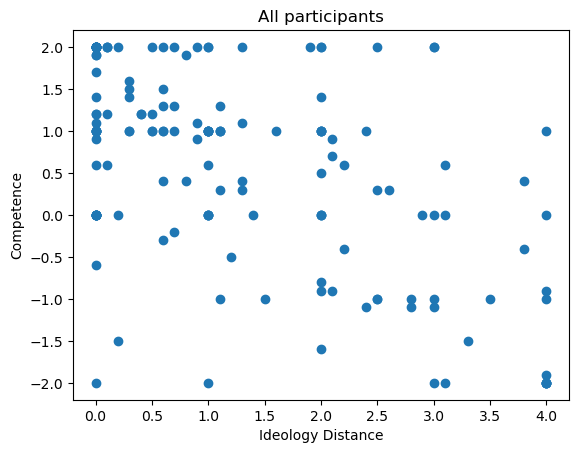

In [9]:
def get_data(df, column_name):
    data = []
    column_list = df[column_name].tolist()
    for two_points in column_list:
        data += two_points
    return data

print("For all participants:")
answer_distance_sum = get_data(df, 'answer_distance_sum')
ideology_distance = get_data(df, 'ideology_distance')
friendliness = get_data(df, 'friendliness')
competence = get_data(df, 'competence')
corr_coefficient, p_value = pearsonr(ideology_distance, answer_distance_sum)
print(f"Correlation of ideology distance and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, answer_distance_sum)
print(f"Correlation of friendliness and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, answer_distance_sum)
print(f"Correlation of competence and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, ideology_distance)
print(f"Correlation of friendliness and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, ideology_distance)
print(f"Correlation of competence and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")

plt.title("All participants")
plt.xlabel("Ideology Distance")
plt.ylabel("Friendliness")
plt.scatter(ideology_distance, friendliness)
plt.savefig("all_friendliness.jpg")

plt.clf()
plt.title("All participants")
plt.xlabel("Ideology Distance")
plt.ylabel("Competence")
plt.scatter(ideology_distance, competence)
plt.savefig("all_competence.jpg")


For all participants that didn't detect bot:
Correlation of ideology distance and answer distance: 0.668, p value: 1.2834651908115929e-11
Correlation of friendliness and answer distance: -0.550, p value: 1.292805652016703e-07
Correlation of competence and answer distance: -0.579, p value: 1.8453538691128784e-08
Correlation of friendliness and ideology distance: -0.602, p value: 3.495971878415622e-09
Correlation of competence and ideology distance: -0.618, p value: 1.0368183516340046e-09


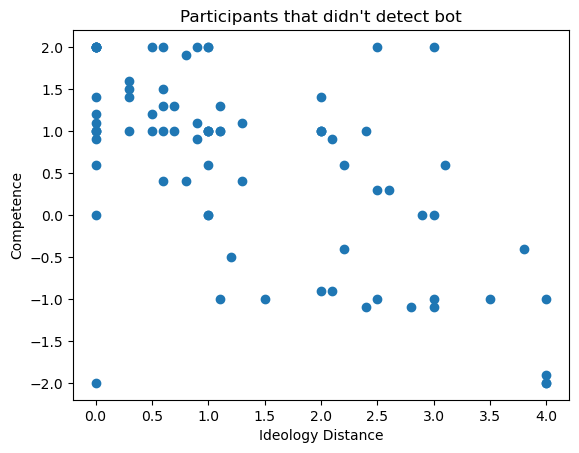

In [14]:
print("\nFor all participants that didn't detect bot:")
df_bot_detected = df[df['bot_detected'] == 0]
answer_distance_sum = get_data(df_bot_detected, 'answer_distance_sum')
ideology_distance = get_data(df_bot_detected, 'ideology_distance')
friendliness = get_data(df_bot_detected, 'friendliness')
competence = get_data(df_bot_detected, 'competence')
corr_coefficient, p_value = pearsonr(ideology_distance, answer_distance_sum)
print(f"Correlation of ideology distance and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, answer_distance_sum)
print(f"Correlation of friendliness and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, answer_distance_sum)
print(f"Correlation of competence and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, ideology_distance)
print(f"Correlation of friendliness and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, ideology_distance)
print(f"Correlation of competence and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")

plt.title("Participants that didn't detect bot")
plt.xlabel("Ideology Distance")
plt.ylabel("Friendliness")
plt.scatter(ideology_distance, friendliness)
plt.savefig("0_friendliness.jpg")

plt.clf()
plt.title("Participants that didn't detect bot")
plt.xlabel("Ideology Distance")
plt.ylabel("Competence")
plt.scatter(ideology_distance, competence)
plt.savefig("0_competence.jpg")


For all participants that detected 1 bot:
Correlation of ideology distance and answer distance: 0.570, p value: 0.0002864534155068561
Correlation of friendliness and answer distance: -0.531, p value: 0.000864463294324365
Correlation of competence and answer distance: -0.537, p value: 0.0007390488919217431
Correlation of friendliness and ideology distance: -0.461, p value: 0.004699763510604985
Correlation of competence and ideology distance: -0.555, p value: 0.00044621725785408064


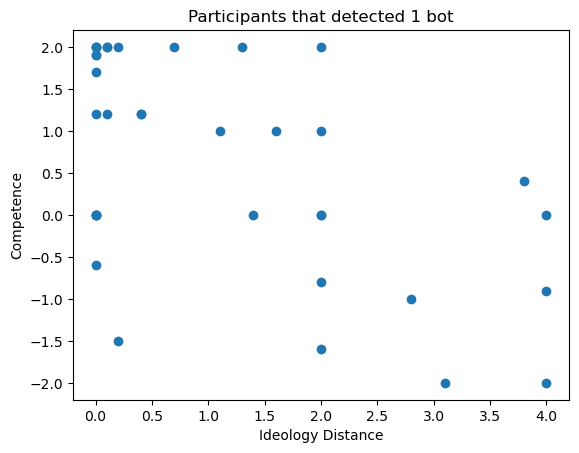

In [11]:
print("\nFor all participants that detected 1 bot:")
df_bot_detected = df[df['bot_detected'] == 1]
answer_distance_sum = get_data(df_bot_detected, 'answer_distance_sum')
ideology_distance = get_data(df_bot_detected, 'ideology_distance')
friendliness = get_data(df_bot_detected, 'friendliness')
competence = get_data(df_bot_detected, 'competence')
corr_coefficient, p_value = pearsonr(ideology_distance, answer_distance_sum)
print(f"Correlation of ideology distance and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, answer_distance_sum)
print(f"Correlation of friendliness and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, answer_distance_sum)
print(f"Correlation of competence and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, ideology_distance)
print(f"Correlation of friendliness and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, ideology_distance)
print(f"Correlation of competence and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")

plt.title("Participants that detected 1 bot")
plt.xlabel("Ideology Distance")
plt.ylabel("Friendliness")
plt.scatter(ideology_distance, friendliness)
plt.savefig("1_friendliness.jpg")

plt.clf()
plt.title("Participants that detected 1 bot")
plt.xlabel("Ideology Distance")
plt.ylabel("Competence")
plt.scatter(ideology_distance, competence)
plt.savefig("1_competence.jpg")


For all participants that detected 2 bots:
Correlation of ideology distance and answer distance: 0.769, p value: 1.7163948986083888e-08
Correlation of friendliness and answer distance: -0.264, p value: 0.1089560998553609
Correlation of competence and answer distance: -0.399, p value: 0.012974741171802587
Correlation of friendliness and ideology distance: -0.413, p value: 0.009974907201587987
Correlation of competence and ideology distance: -0.470, p value: 0.0029280134089989243


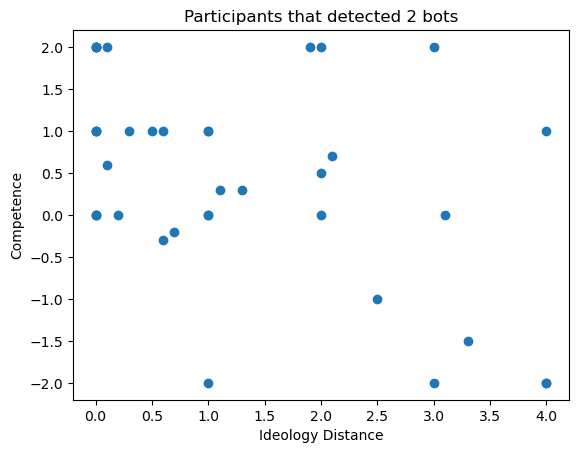

In [12]:
print("\nFor all participants that detected 2 bots:")
df_bot_detected = df[df['bot_detected'] == 2]
answer_distance_sum = get_data(df_bot_detected, 'answer_distance_sum')
ideology_distance = get_data(df_bot_detected, 'ideology_distance')
friendliness = get_data(df_bot_detected, 'friendliness')
competence = get_data(df_bot_detected, 'competence')
corr_coefficient, p_value = pearsonr(ideology_distance, answer_distance_sum)
print(f"Correlation of ideology distance and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, answer_distance_sum)
print(f"Correlation of friendliness and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, answer_distance_sum)
print(f"Correlation of competence and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, ideology_distance)
print(f"Correlation of friendliness and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, ideology_distance)
print(f"Correlation of competence and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")

plt.title("Participants that detected 2 bots")
plt.xlabel("Ideology Distance")
plt.ylabel("Friendliness")
plt.scatter(ideology_distance, friendliness)
plt.savefig("2_friendliness.jpg")

plt.clf()
plt.title("Participants that detected 2 bots")
plt.xlabel("Ideology Distance")
plt.ylabel("Competence")
plt.scatter(ideology_distance, competence)
plt.savefig("2_competence.jpg")


For all participants that detected at least 1 bot:
Correlation of ideology distance and answer distance: 0.674, p value: 4.579279771186341e-11
Correlation of friendliness and answer distance: -0.368, p value: 0.0012704050943840922
Correlation of competence and answer distance: -0.457, p value: 4.262276809583766e-05
Correlation of friendliness and ideology distance: -0.433, p value: 0.00011598920928042074
Correlation of competence and ideology distance: -0.514, p value: 2.7911829774810872e-06


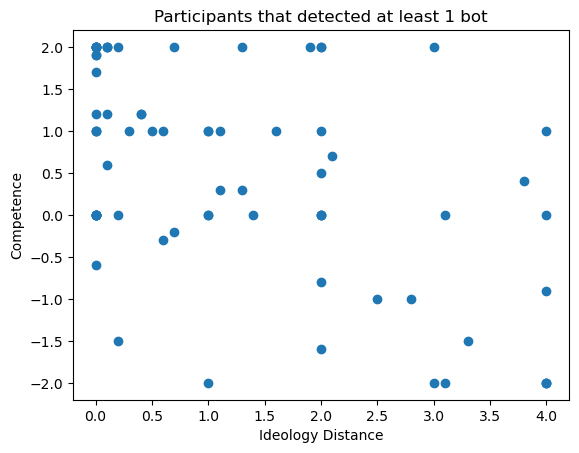

In [13]:
print("\nFor all participants that detected at least 1 bot:")
df_bot_detected = df[df['bot_detected'] >= 1]
answer_distance_sum = get_data(df_bot_detected, 'answer_distance_sum')
ideology_distance = get_data(df_bot_detected, 'ideology_distance')
friendliness = get_data(df_bot_detected, 'friendliness')
competence = get_data(df_bot_detected, 'competence')
corr_coefficient, p_value = pearsonr(ideology_distance, answer_distance_sum)
print(f"Correlation of ideology distance and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, answer_distance_sum)
print(f"Correlation of friendliness and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, answer_distance_sum)
print(f"Correlation of competence and answer distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(friendliness, ideology_distance)
print(f"Correlation of friendliness and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")
corr_coefficient, p_value = pearsonr(competence, ideology_distance)
print(f"Correlation of competence and ideology distance: {corr_coefficient:.3f}, p value: {p_value}")

plt.title("Participants that detected at least 1 bot")
plt.xlabel("Ideology Distance")
plt.ylabel("Friendliness")
plt.scatter(ideology_distance, friendliness)
plt.savefig("12_friendliness.jpg")

plt.clf()
plt.title("Participants that detected at least 1 bot")
plt.xlabel("Ideology Distance")
plt.ylabel("Competence")
plt.scatter(ideology_distance, competence)
plt.savefig("12_competence.jpg")

In [1]:
from scipy.stats import ttest_ind
import numpy as np

# Define the samples
sample1 = np.array([1, 2, 3, 4, 5])
sample2 = np.array([6, 7, 8, 9, 10, 11, 12])

# Perform t-test
t_statistic, p_value = ttest_ind(sample1, sample2)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -5.256574830378469
P-Value: 0.00036987470986406013
